# The Varieties of Clustering ... and Penguins

In what follows I want to illustrate how different clustering algorithms work. I'll be applying the techniques to the penguins dataset inside the `seaborn` library. First I'll import the tools I'll need.

In [1]:
import matplotlib as mpl
import seaborn as sns
from sklearn.cluster import AffinityPropagation,\
AgglomerativeClustering, Birch, DBSCAN, KMeans, MeanShift,\
OPTICS, SpectralClustering
from sklearn.mixture import GaussianMixture
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

In [2]:
mpl.pyplot.style.use('fivethirtyeight')
mpl.pyplot.set_cmap('Spectral')

<Figure size 432x288 with 0 Axes>

## Data Preparation

Since I want to use 2-dimensional graphs to illustrate `sklearn`'s clustering techniques, I want to choose features of the penguins data that serve to distinguish the species well one from another. There are three species in the dataset: Adelie, Chinstrap, and Gentoo.

In [3]:
# Loading the data

penguins = sns.load_dataset('penguins')

### Investigating Null Values

In [4]:
penguins.isnull().sum().sum()

19

Since there are only 19 null values in the whole dataset, I'll just drop the offending rows.

In [5]:
penguins_clean = penguins.dropna()

### Dummying out Categorical Variables

In [6]:
penguins_cat = pd.get_dummies(penguins_clean)

### Searching for Predictive Features

I've dummied out the species feature, so I'll check correlation values for each species with the remaining features.

In [7]:
adel_corrs = abs(penguins_cat.corr()['species_Adelie']).sort_values(ascending=False)
adel_corrs

species_Adelie       1.000000
culmen_length_mm     0.836409
flipper_length_mm    0.685947
species_Gentoo       0.658904
body_mass_g          0.550479
culmen_depth_mm      0.531342
island_Torgersen     0.458786
species_Chinstrap    0.447597
island_Biscoe        0.332518
island_Dream         0.013443
sex_FEMALE           0.007961
sex_MALE             0.007961
Name: species_Adelie, dtype: float64

In [8]:
print(penguins_cat.corr()['species_Adelie']['culmen_length_mm'])
print(penguins_cat.corr()['species_Adelie']['flipper_length_mm'])

-0.8364086939195837
-0.6859472579700764


Short culmens and short flippers are most highly correlated with belonging to the Adelie species.

In [9]:
chin_corrs = abs(penguins_cat.corr()['species_Chinstrap']).sort_values(ascending=False)
chin_corrs

species_Chinstrap    1.000000
island_Dream         0.661894
island_Biscoe        0.496022
culmen_length_mm     0.449098
species_Adelie       0.447597
species_Gentoo       0.377744
culmen_depth_mm      0.323505
body_mass_g          0.298622
island_Torgersen     0.205351
flipper_length_mm    0.186175
sex_MALE             0.004564
sex_FEMALE           0.004564
Name: species_Chinstrap, dtype: float64

In [10]:
print(penguins_cat.corr()['species_Chinstrap']['island_Dream'])
print(penguins_cat.corr()['species_Chinstrap']['island_Biscoe'])

0.6618942541536033
-0.49602191065421586


Being from Dream Island and *not* being from Biscoe Island are most highly correlated with belonging to the Chinstrap species.

In [11]:
gen_corrs = abs(penguins_cat.corr()['species_Gentoo']).sort_values(ascending=False)
gen_corrs

species_Gentoo       1.000000
flipper_length_mm    0.866854
culmen_depth_mm      0.822293
body_mass_g          0.821178
island_Biscoe        0.761548
species_Adelie       0.658904
island_Dream         0.570702
culmen_length_mm     0.488256
species_Chinstrap    0.377744
island_Torgersen     0.302296
sex_FEMALE           0.012082
sex_MALE             0.012082
Name: species_Gentoo, dtype: float64

In [12]:
print(penguins_cat.corr()['species_Gentoo']['flipper_length_mm'])
print(penguins_cat.corr()['species_Gentoo']['culmen_depth_mm'])

0.8668535861431634
-0.8222930327708879


Long flippers and shallow culmens are most highly correlated with belonging to the Gentoo species.

#### Choosing Final Features

We looked at the top two most highly correlated features for each species and found five different features across the dataset. To make our choice of the two we'll use for plotting purposes, we'll take a weighted average of the (absolute values of the) correlations across the three species.

In [13]:
# Calculating the ratios of species representation in the dataset

adel_rat = penguins_cat['species_Adelie'].sum() / penguins_cat.shape[0]
chin_rat = penguins_cat['species_Chinstrap'].sum() / penguins_cat.shape[0]
gen_rat = penguins_cat['species_Gentoo'].sum() / penguins_cat.shape[0]

In [14]:
# Calculating the weighted average of correlations

(adel_rat * adel_corrs + chin_rat * chin_corrs + gen_rat * gen_corrs)\
          .sort_values(ascending=False)

species_Adelie       0.765304
species_Gentoo       0.723383
flipper_length_mm    0.648540
culmen_length_mm     0.632903
body_mass_g          0.595785
culmen_depth_mm      0.592874
species_Chinstrap    0.535438
island_Biscoe        0.519223
island_Torgersen     0.351111
island_Dream         0.345000
sex_FEMALE           0.008740
sex_MALE             0.008740
dtype: float64

Ignoring the species features themselves, our top scorers are flipper length and culmen length, so we'll go with those.

These are both numeric features, so we'll go back to our dataset without the dummies. In order to be able to pass the species into `matplotlib` plots' color parameter, we'll also use `sklearn`'s `LabelEncoder` class.

In [15]:
pen_species = LabelEncoder()
pen_species.fit(penguins_clean['species'])

penguins_num = penguins_clean.copy()
penguins_num['spec_num'] = pen_species.transform(penguins_num['species'])

## Plotting the Ground Truth

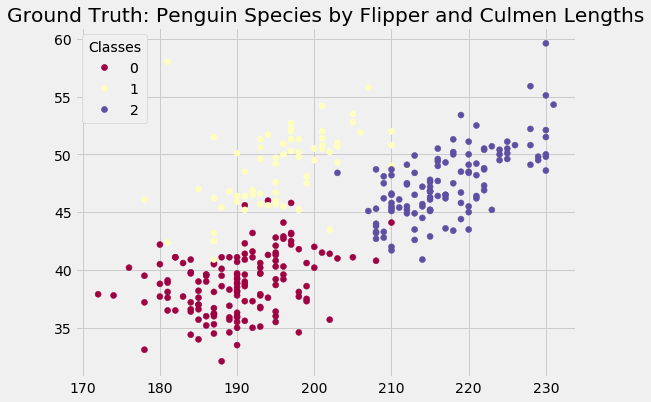

In [16]:
fig, ax = mpl.pyplot.subplots(figsize=(8, 6))

scatter = ax.scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax.add_artist(legend1)
ax.set_title('Ground Truth: Penguin Species by Flipper and Culmen Lengths');

### Verifying our Species Identities

In [17]:
pen_species.classes_

array(['Adelie', 'Chinstrap', 'Gentoo'], dtype=object)

- Class 0 represents Adelie
- Class 1 represents Chinstrap
- Class 2 represents Gentoo

If we calculate the means of Adelie flipper and culmen lengths, we should find the center of the reddish region above:

In [18]:
print(penguins_num[penguins_num['species'] == 'Adelie']['flipper_length_mm'].mean())
print(penguins_num[penguins_num['species'] == 'Adelie']['culmen_length_mm'].mean())

190.1027397260274
38.82397260273974


If we calculate the means of Chinstrap flipper and culmen lengths, we should find the center of the yellowish region above:

In [19]:
print(penguins_num[penguins_num['species'] == 'Chinstrap']['flipper_length_mm'].mean())
print(penguins_num[penguins_num['species'] == 'Chinstrap']['culmen_length_mm'].mean())

195.8235294117647
48.83382352941177


If we calculate the means of Gentoo flipper and culmen lengths, we should find the center of the bluish region above:

In [20]:
print(penguins_num[penguins_num['species'] == 'Gentoo']['flipper_length_mm'].mean())
print(penguins_num[penguins_num['species'] == 'Gentoo']['culmen_length_mm'].mean())

217.23529411764707
47.56806722689075


## Final Preparation

The last thing we want to do is to drop the species column so that we can train our clustering algorithms without any information about the ground truth.

In [21]:
penguins_X = penguins_num.drop('species', axis=1)\
[['flipper_length_mm', 'culmen_length_mm']]

## Clustering

### Strategy 1: Affinity Propagation

Affinity propagation is about finding exemplars for clusters. The goal is to find data points that serve well as exemplars based on their similarity (distance) to the other points. The `damping` parameter, as the name suggets, helps to prevent oscillations.

The number of final clusters is not determined in advance. Observe the different predictions resulting from only slight changes in the starting datset below:

In [22]:
var1 = np.array([1, 2, 3, 4])[:, np.newaxis]
var2 = np.array([1, 2, 4, 5])[:, np.newaxis]
var3 = np.array([1, 3, 4, 5])[:, np.newaxis]
var4 = np.array([1, 2, 3, 5])[:, np.newaxis]

print(AffinityPropagation().fit_predict(var1))
print(AffinityPropagation().fit_predict(var2))
print(AffinityPropagation().fit_predict(var3))
print(AffinityPropagation().fit_predict(var4))

[0 0 0 0]
[0 0 1 1]
[0 1 1 1]
[0 0 0 1]


The predictions are the clusters to which each point is predicted to belong. See `sklearn` documentation [here](https://scikit-learn.org/stable/modules/clustering.html#affinity-propagation).

In [23]:
aff = AffinityPropagation()
# default settings first

aff.fit(penguins_X)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=None, verbose=False)

In [24]:
preds1 = aff.predict(penguins_X)

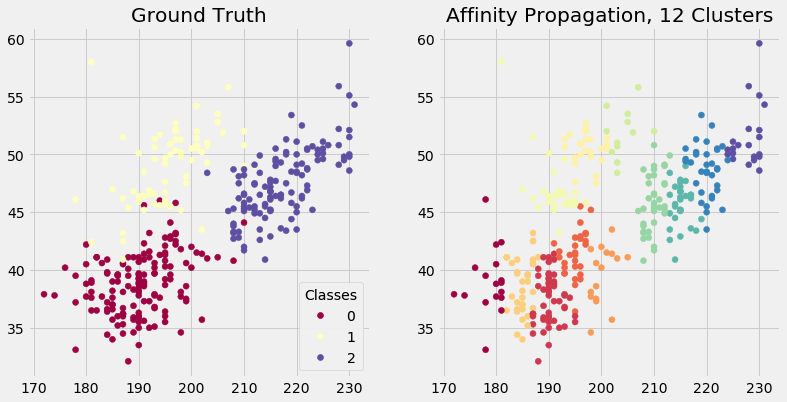

In [25]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=preds1)
ax[1].set_title(f'Affinity Propagation, {len(np.unique(preds1))} Clusters');

#### Adjust `damping`

In [26]:
aff2 = AffinityPropagation(damping=0.975)
# We'll try setting the damping up toward the higher end

aff2.fit(penguins_X)

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.975, max_iter=200, preference=None,
                    verbose=False)

In [27]:
preds1b = aff2.predict(penguins_X)

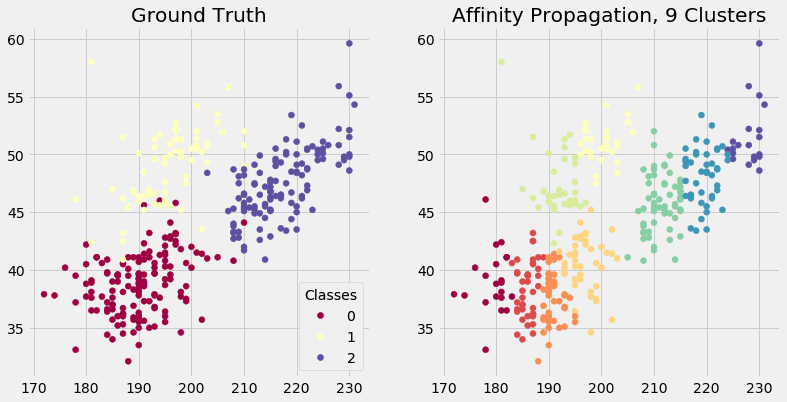

In [28]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=preds1b)
ax[1].set_title(f'Affinity Propagation, {len(np.unique(preds1b))} Clusters');

### Strategy 2: Agglomerative Clustering

Agglomerative clustering is a "bottom-up" mode of hierarchical clustering: Call each point its own cluster. Then find the two clusters that are most similar and merge those into a new cluster. Then find the next two closest clusters and merge them. Repeat until a desired number of clusters is reached. See `sklearn` documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html).

In [29]:
agg = AgglomerativeClustering(n_clusters=3)
# Setting to 3 clusters

In [30]:
preds2 = agg.fit_predict(penguins_X)

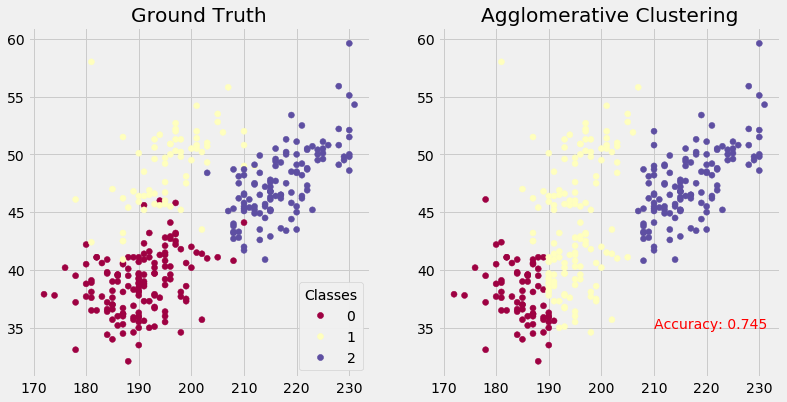

In [31]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 0:
        return 2
    elif num == 2:
        return 0
    else:
        return num

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=list(map(switch, preds2)))
ax[1].set_title(f'Agglomerative Clustering')

acc = round(accuracy_score(penguins_num['spec_num'], list(map(switch, preds2))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');

#### Try single `linkage`

In [32]:
agg2 = AgglomerativeClustering(n_clusters=3, linkage='single')
# Trying the "nearest point" single linkage

In [33]:
preds2b = agg2.fit_predict(penguins_X)

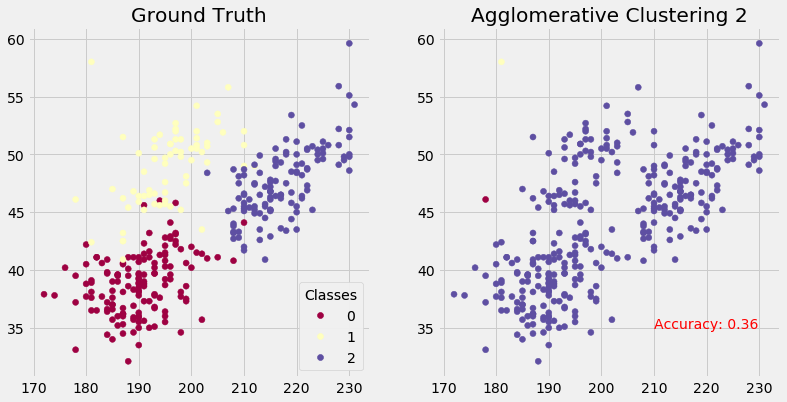

In [34]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 0:
        return 2
    elif num == 2:
        return 0
    else:
        return num

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=list(map(switch, preds2b)))
ax[1].set_title(f'Agglomerative Clustering 2')

acc = round(accuracy_score(penguins_num['spec_num'], list(map(switch, preds2b))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');

#### Try complete `linkage`

In [35]:
agg3 = AgglomerativeClustering(n_clusters=3, linkage='complete')
# Trying the "farthest point" complete linkage

In [36]:
preds2c = agg3.fit_predict(penguins_X)

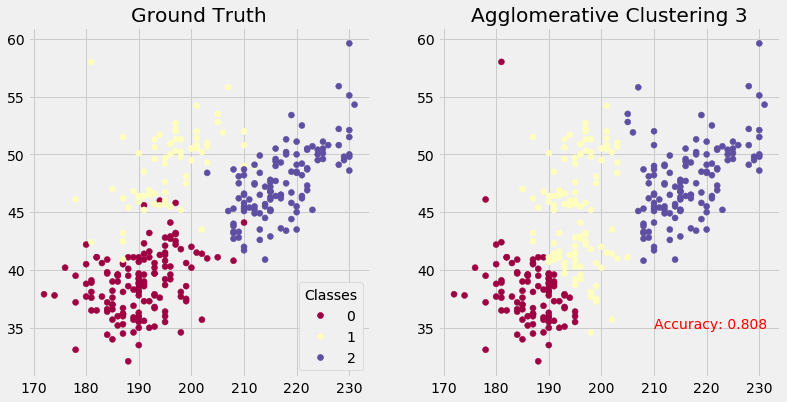

In [37]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 0:
        return 2
    elif num == 1:
        return 0
    else:
        return 1

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=list(map(switch, preds2c)))
ax[1].set_title(f'Agglomerative Clustering 3')

acc = round(accuracy_score(penguins_num['spec_num'], list(map(switch, preds2c))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');

### Strategy 3: Birch Clustering

Birch clustering constructs a kind of dendrogram à la hierarchical clustering, but its performance is often similar to k-means clustering. It is most useful for datasets with many rows but few columns and it can also handle a certain amount of noise in the data. The `threshold` parameter determines how close subclusters need to be before merging. See `sklearn` documentation [here](https://scikit-learn.org/stable/modules/clustering.html#birch).

In [38]:
birch = Birch()

birch.fit(penguins_X)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=3,
      threshold=0.5)

In [39]:
preds3 = birch.predict(penguins_X)

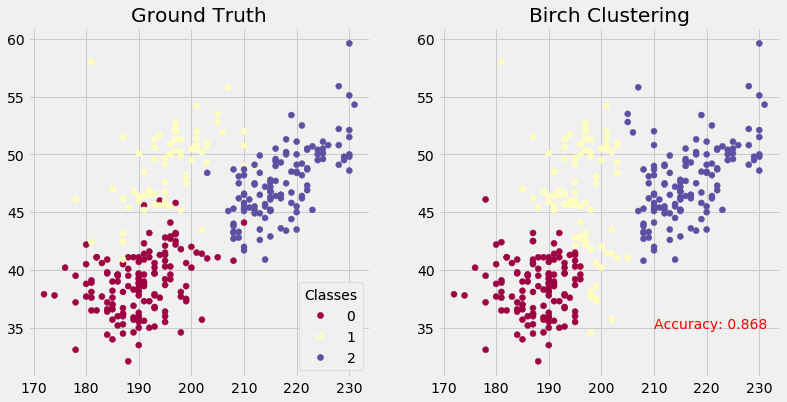

In [40]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 0:
        return 2
    elif num == 1:
        return 0
    else:
        return 1

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=list(map(switch, preds3)))
ax[1].set_title(f'Birch Clustering')

acc = round(accuracy_score(penguins_num['spec_num'], list(map(switch, preds3))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');

#### Adjusting `threshold`

In [41]:
birch2 = Birch(threshold=5)

birch2.fit(penguins_X)

Birch(branching_factor=50, compute_labels=True, copy=True, n_clusters=3,
      threshold=5)

In [42]:
preds3b = birch2.predict(penguins_X)

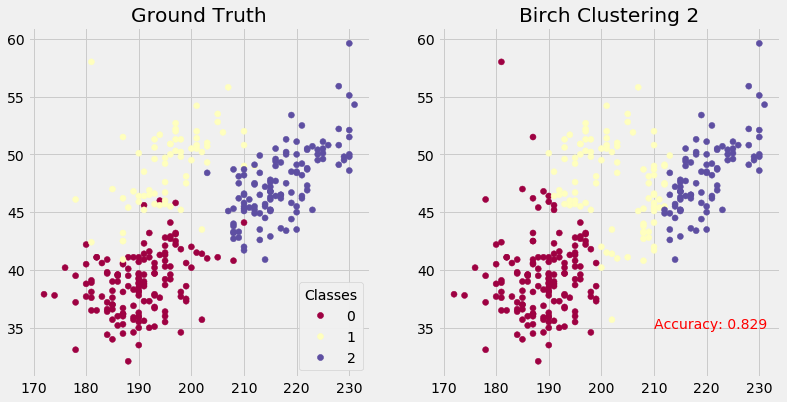

In [43]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 1:
        return 2
    elif num == 2:
        return 1
    else:
        return num

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=list(map(switch, preds3b)))
ax[1].set_title(f'Birch Clustering 2')

acc = round(accuracy_score(penguins_num['spec_num'], list(map(switch, preds3b))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');

### Strategy 4: Density-Based Spatial Clustering of Applications with Noise (DBSCAN)

DBSCAN clusters points according to *density*. When sufficiently many points are sufficiently close together (the user can modify these), then those points are called a cluster. See `sklearn` documentation [here](https://scikit-learn.org/stable/modules/clustering.html#dbscan).

In [44]:
dbs = DBSCAN()

In [45]:
preds4 = dbs.fit_predict(penguins_X)

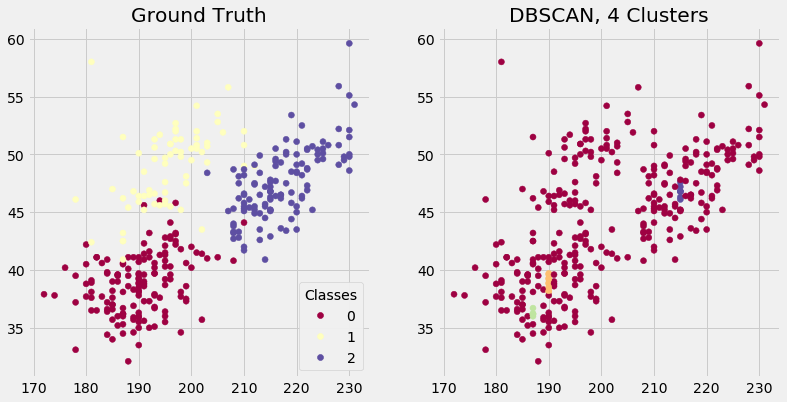

In [46]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=preds4)
ax[1].set_title(f'DBSCAN, {len(np.unique(preds4))} Clusters');

#### Adjusting `eps`, `min_samples`

Let's try increasing `eps` and decreasing `min_samples`.

In [47]:
dbs2 = DBSCAN(eps=2, min_samples=4)

In [48]:
preds4b = dbs2.fit_predict(penguins_X)

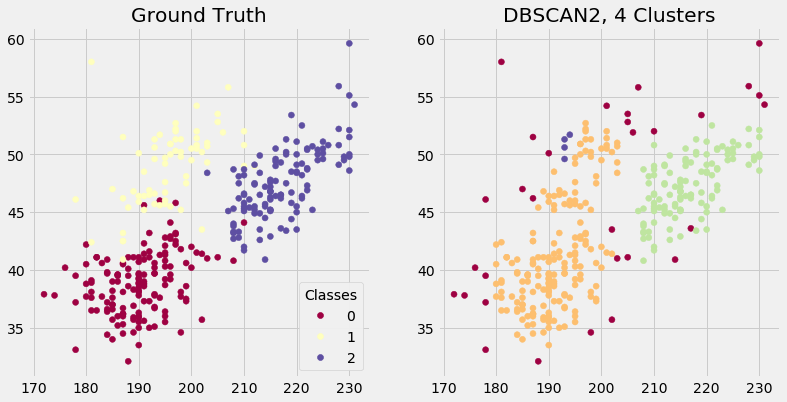

In [49]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=preds4b)
ax[1].set_title(f'DBSCAN2, {len(np.unique(preds4b))} Clusters');

### Strategy 5: Gaussian Mixture Modeling

A Gaussian mixture is what it sounds like: A model that treats the data as belonging to distinct normal distributions. The `sklearn` tool lets us choose the number of groups we're modeling. See `sklearn` documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html).

In [50]:
gauss = GaussianMixture(n_components=3, random_state=42)

gauss.fit(penguins_X)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [51]:
preds5 = gauss.predict(penguins_X)

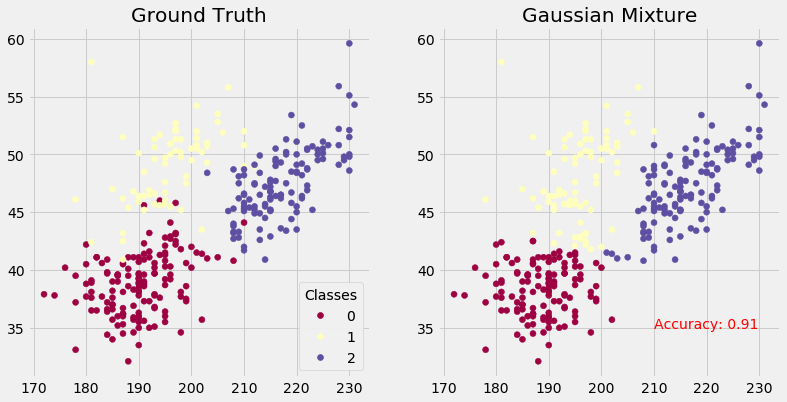

In [52]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 1:
        return 2
    elif num == 2:
        return 1
    else:
        return num

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=list(map(switch, preds5)))
ax[1].set_title(f'Gaussian Mixture')

acc = round(accuracy_score(penguins_num['spec_num'], list(map(switch, preds5))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');

#### Adjusting `covariance_type`

The covariance matrix is one way of [describing a Gaussian](https://stats.stackexchange.com/questions/326671/different-covariance-types-for-gaussian-mixture-models) distribution. Since our groups have roughly the same shape, we might try the 'tied' type.

In [53]:
gauss2 = GaussianMixture(n_components=3, covariance_type='tied',
                        random_state=42)

gauss2.fit(penguins_X)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [54]:
preds5b = gauss2.predict(penguins_X)

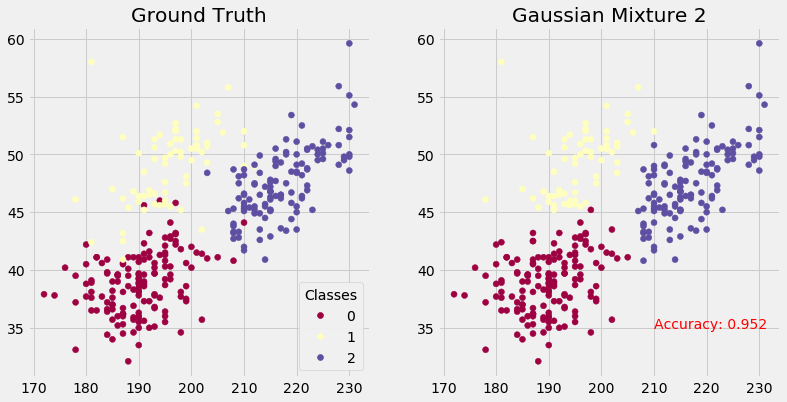

In [55]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 1:
        return 2
    elif num == 2:
        return 1
    else:
        return num

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=list(map(switch, preds5b)))
ax[1].set_title(f'Gaussian Mixture 2')

acc = round(accuracy_score(penguins_num['spec_num'], list(map(switch, preds5b))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');

### Strategy 6: Mean Shift

The mean shift strategy is in the general family of centroid approaches to clustering that includes $k$-means, but mean shift does not require a number of clusters to be selected in advance. A `bandwidth` parameter can be set that will determine the size of the area to be searched for nearest neighbors. See sklearn documentation [here](https://scikit-learn.org/stable/modules/clustering.html#mean-shift).

In [56]:
ms = MeanShift()

ms.fit(penguins_X)

MeanShift(bandwidth=None, bin_seeding=False, cluster_all=True, max_iter=300,
          min_bin_freq=1, n_jobs=None, seeds=None)

In [57]:
preds6 = ms.predict(penguins_X)

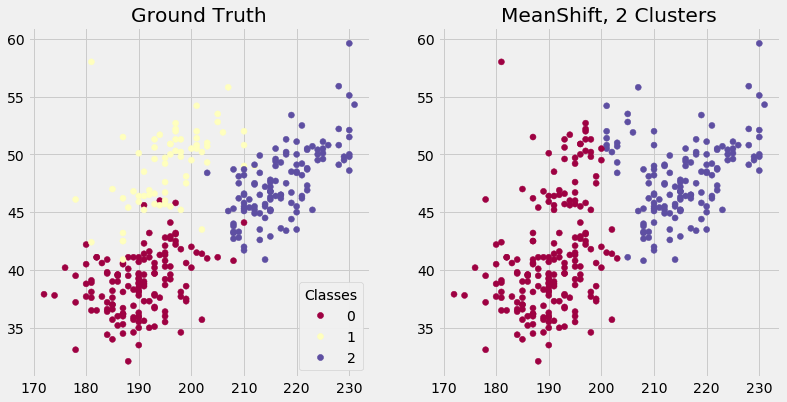

In [58]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=preds6)
ax[1].set_title(f'MeanShift, {len(np.unique(preds6))} Clusters');

In [59]:
from sklearn.cluster import estimate_bandwidth

In [60]:
estimate_bandwidth(penguins_X)

10.12883243831422

#### Adjusting `bandwidth`

The bandwidth estimate above led to only two clusters. Let's see if wee can alter it so as to produce three.

In [61]:
ms2 = MeanShift(bandwidth=8)

ms2.fit(penguins_X)

MeanShift(bandwidth=8, bin_seeding=False, cluster_all=True, max_iter=300,
          min_bin_freq=1, n_jobs=None, seeds=None)

In [62]:
preds6b = ms2.predict(penguins_X)

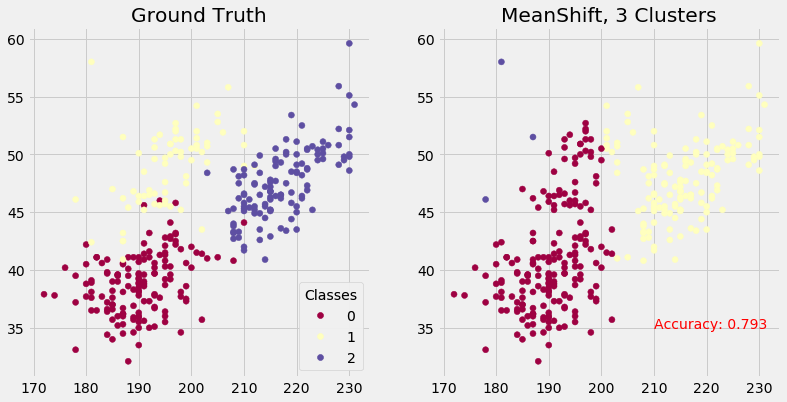

In [63]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 1:
        return 2
    elif num == 2:
        return 1
    else:
        return num

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=preds6b)
ax[1].set_title(f'MeanShift, {len(np.unique(preds6b))} Clusters')

acc = round(accuracy_score(penguins_num['spec_num'], list(map(switch, preds6b))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');

### Strategy 7: $k$-Means

The $k$-means strategy is one of the most popular clustering algorithms. Centroids are first chosen randomly. Then points are assigned clusters based on the nearest centroid. Then centroid positions are updated and the process repeats. See `sklearn` documentation [here](https://scikit-learn.org/stable/modules/clustering.html#k-means).

In [64]:
kmeans = KMeans(n_clusters=3, random_state=42)

kmeans.fit(penguins_X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [65]:
preds7 = kmeans.predict(penguins_X)

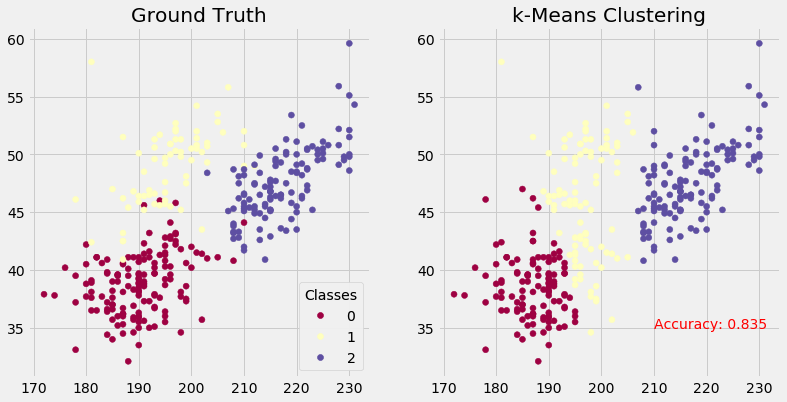

In [66]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 1:
        return 2
    elif num == 2:
        return 1
    else:
        return num

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=list(map(switch, preds7)))
ax[1].set_title(f'k-Means Clustering')

acc = round(accuracy_score(penguins_num['spec_num'],
                           list(map(switch, preds7))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');

### Strategy 8: OPTICS

OPTICS is in the same family as DBSCAN, but it uses an epsilon range rather than a single value. Data points have reachability and ordering scores. See `sklearn` documentation [here](https://scikit-learn.org/stable/modules/clustering.html#optics).

In [67]:
optics = OPTICS()

In [68]:
preds8 = optics.fit_predict(penguins_X)

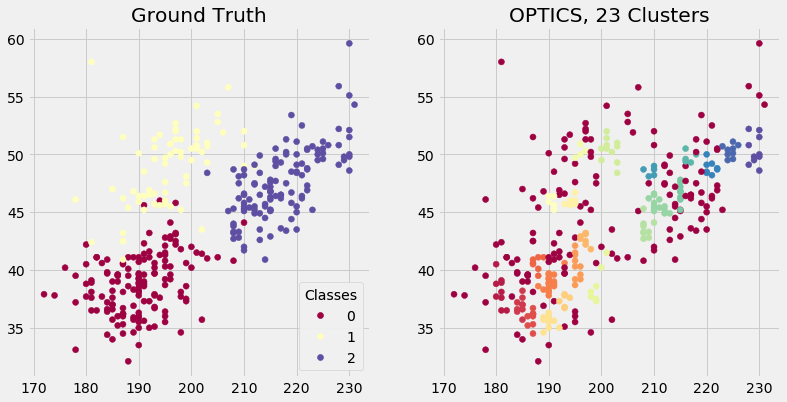

In [69]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=preds8)
ax[1].set_title(f'OPTICS, {len(np.unique(preds8))} Clusters');

#### Adjusting `min_cluster_size`

This defaults to 5. Since we got so many clusters with that setting, let's try a larger number.

In [70]:
optics2 = OPTICS(min_cluster_size=20)

In [71]:
preds8b = optics2.fit_predict(penguins_X)

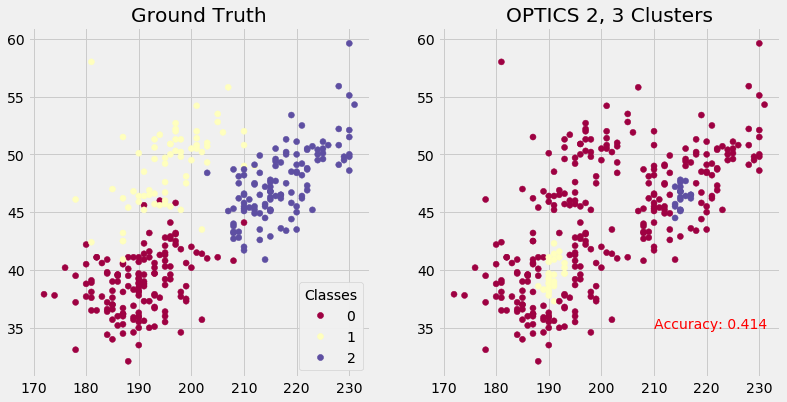

In [72]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 0:
        return 1
    elif num == 1:
        return 2
    else:
        return 0

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=preds8b)
ax[1].set_title(f'OPTICS 2, {len(np.unique(preds8b))} Clusters')

acc = round(accuracy_score(penguins_num['spec_num'],
                           list(map(switch, preds8b))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');

### Strategy 9: Spectral

Spectral clustering transforms the problem to a lower-dimensional one and then clusters eigenvector components in the lower-dimensional space.

In [73]:
spec = SpectralClustering(n_clusters=3, random_state=42)

In [74]:
preds9 = spec.fit_predict(penguins_X)

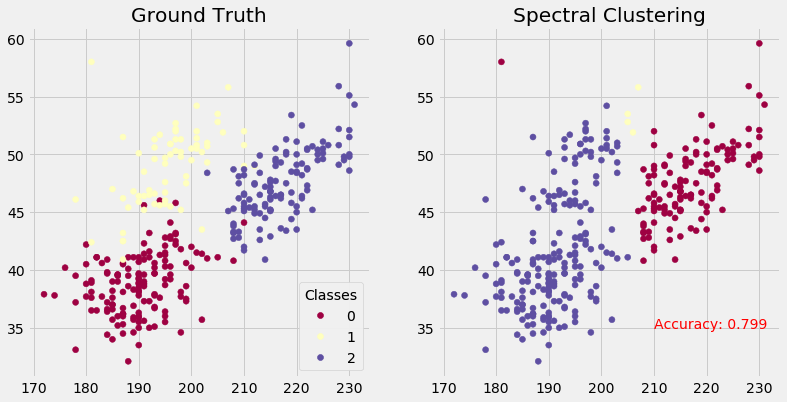

In [75]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 0:
        return 2
    elif num == 2:
        return 0
    else:
        return num

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=preds9)
ax[1].set_title(f'Spectral Clustering')

acc = round(accuracy_score(penguins_num['spec_num'],
                           list(map(switch, preds9))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');

In [76]:
spec2 = SpectralClustering(n_clusters=3, affinity='nearest_neighbors',
                         n_neighbors=7)

In [77]:
preds9b = spec2.fit_predict(penguins_X)

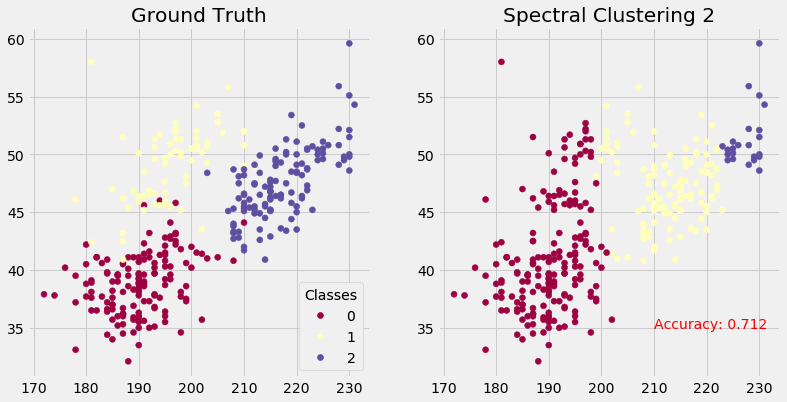

In [83]:
fig, ax = mpl.pyplot.subplots(1, 2, figsize=(12, 6))

scatter = ax[0].scatter(x=penguins_num['flipper_length_mm'],
          y=penguins_num['culmen_length_mm'],
          c=penguins_num['spec_num'])

legend1 = ax[0].legend(*scatter.legend_elements(),
                    loc="best", title="Classes")
ax[0].add_artist(legend1)
ax[0].set_title('Ground Truth')

def switch(num):
    if num == 1:
        return 2
    elif num == 2:
        return 1
    else:
        return num

ax[1].scatter(x=penguins_X['flipper_length_mm'],
          y=penguins_X['culmen_length_mm'],
          c=preds9b)
ax[1].set_title(f'Spectral Clustering 2')

acc = round(accuracy_score(penguins_num['spec_num'],
                           list(map(switch, preds9b))), 3)
ax[1].text(x=210, y=35, s=f'Accuracy: {acc}', c='r');